In [1]:
import numpy as np
import mpi4py.MPI
import dolfinx

In [2]:
import dolfinx.fem
import dolfinx.fem.petsc
import dolfinx.mesh
import mpi4py.MPI
import numpy as np
import petsc4py.PETSc
import ufl

In [64]:
import viskex
import matplotlib.pyplot as plt
import pyvista
from dolfinx import plot

In [4]:
from FEM_FENICS_Proj import unit_square_poisson_solve as pois_solv
from FEM_FENICS_Proj import unit_square_solution_error as pois_err
from FEM_FENICS_Proj import unit_square_structured_mesh

We consider the model boundary value problem: find $u: \Omega = (0, 1)^2 \to \mathbb{R}$ such that

$$
\left\{
\begin{array}{l}
- \Delta u = f, & x \in \Omega\\
u = g, & x \in \partial\Omega

\end{array}
\right.
$$

with $f\equiv 1$ and the boundary value $g(\mathbf{x})$ given by
$$
g(\mathbf{x}) = g(x_0, x_1) = \sin(3 \pi x_0 + 1) \ \sin(3 \pi x_1 + 1).
$$






**Task 1: create a mesh.** As first example, we generate a triangular mesh of the domain $\Omega$, dividing both the horizontal and vertical sides of the square in $n$ x $m$ equispaced subintervals.

Similarly to 1D case, `dolfinx.mesh` provides the function `create_unit_square` for this task.

In [5]:
n = 10
m = 15
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

Let's see how many cells are in the mesh.

We store in:
* tdim: the problem dimension (2)
* fdim: the mesh scheleton entities dimension (1)
* num_cells: the number of triangles in the mesh

We can extract the num_cells information as we did in the 1D case from the connectivity or directly...

In [6]:
tdim = mesh.topology.dim
print(tdim)
fdim = tdim - 1

connectivity_cells_to_vertices = mesh.topology.connectivity(mesh.topology.dim,0)
print(connectivity_cells_to_vertices)
num_cells = len(connectivity_cells_to_vertices)
print(num_cells)

num_cells = mesh.topology.index_map(tdim).size_local
print(num_cells)

2
<AdjacencyList> with 300 nodes
  0: [0 1 2 ]
  1: [0 3 2 ]
  2: [4 0 3 ]
  3: [3 2 5 ]
  4: [4 6 3 ]
  5: [3 7 5 ]
  6: [8 4 6 ]
  7: [6 3 7 ]
  8: [7 5 9 ]
  9: [8 10 6 ]
  10: [6 11 7 ]
  11: [7 12 9 ]
  12: [13 8 10 ]
  13: [10 6 11 ]
  14: [11 7 12 ]
  15: [12 9 14 ]
  16: [13 15 10 ]
  17: [10 16 11 ]
  18: [11 17 12 ]
  19: [12 18 14 ]
  20: [19 13 15 ]
  21: [15 10 16 ]
  22: [16 11 17 ]
  23: [17 12 18 ]
  24: [18 14 20 ]
  25: [19 21 15 ]
  26: [15 22 16 ]
  27: [16 23 17 ]
  28: [17 24 18 ]
  29: [18 25 20 ]
  30: [26 19 21 ]
  31: [21 15 22 ]
  32: [22 16 23 ]
  33: [23 17 24 ]
  34: [24 18 25 ]
  35: [25 20 27 ]
  36: [26 28 21 ]
  37: [21 29 22 ]
  38: [22 30 23 ]
  39: [23 31 24 ]
  40: [24 32 25 ]
  41: [25 33 27 ]
  42: [34 26 28 ]
  43: [28 21 29 ]
  44: [29 22 30 ]
  45: [30 23 31 ]
  46: [31 24 32 ]
  47: [32 25 33 ]
  48: [33 27 35 ]
  49: [34 36 28 ]
  50: [28 37 29 ]
  51: [29 38 30 ]
  52: [30 39 31 ]
  53: [31 40 32 ]
  54: [32 41 33 ]
  55: [33 42 35 ]
  56: 

We can obtain an interactive plot of the domain using `pyvista`. (Click on the menu: next to the dropdown that contains "Geometry 0" you may find three different representations: the domain itself, the edges of the mesh, and both overlayed.)

In [ ]:
viskex.dolfinx.plot_mesh(mesh)

Exception raised
KeyError('a93a84a44f713b138b32a48c6b9b23f4_200d')
Traceback (most recent call last):
  File "/home/matteo/miniconda3/envs/myenv/lib/python3.9/site-packages/wslink/protocol.py", line 313, in onCompleteMessage
    results = func(*args, **kwargs)
  File "/home/matteo/miniconda3/envs/myenv/lib/python3.9/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/matteo/miniconda3/envs/myenv/lib/python3.9/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: 'a93a84a44f713b138b32a48c6b9b23f4_200d'

Exception raised
KeyError('6696cd8520d3d3e4286e98cde3effa31_121d')
Traceback (most recent call last):
  File "/home/matteo/miniconda3/envs/myenv/lib/python3.9/site-packages/wslink/protocol.py", line 313, in onCompleteMessage
    results = func(*args, **kwargs)
  File "/h

**Task 2:** Determine IDs of boundary edges in view of the application of the Dirichlet boundary condition.

As in 1D case, this is obtained via the `dolfinx.mesh` `locate_entities_boundary` function. We want all edges on the boundary, but the function always requires a third input to permit the selection of parts of the boundary. As a workaround to this, we pass as third argument the function which always returns `True`.

In [8]:
boundary_entities = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.full((x.shape[1], ), True))
boundary_entities

array([  0,   3,   4,   6,  12,  14,  23,  25,  37,  39,  54,  56,  74,
        76,  97,  99, 123, 125, 152, 154, 183, 185, 187, 216, 218, 247,
       249, 278, 280, 309, 311, 339, 341, 366, 368, 390, 392, 411, 413,
       429, 431, 444, 446, 456, 458, 465, 467, 471, 473, 474], dtype=int32)

We can store the boundary entites in a `dolfinx.mesh` `MeshTags` object, and plot it using `viskex` to check this was done correctly.

In [9]:
boundaries = dolfinx.mesh.meshtags(
    mesh, fdim, boundary_entities, np.ones_like(boundary_entities))

viskex.dolfinx.plot_mesh_tags(mesh, boundaries, "boundaries")

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b06c74df0_1&reconnect=auto" class="pyvi…

**Task 3: create FEM space.**

Define the finite element function space $V_h$ using $\mathbb{P}_1$ Lagrange elements.

This part of the code is indistinguishable from the 1D version...

In [10]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))
Vh_dim = Vh.dofmap.index_map.size_local
Vh_dim

176

Once the FE space is at hand, we introduce ufl symbols to define the trial and test functions for our weak formulation:

In [11]:
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

In [12]:
uh

Argument(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 1, None)

**Task 4:** set up FEM system

We produce the weak formulation of the problem: find $u_h\in V_h$ such that
$$ \int_\Omega \nabla u \cdot \nabla v \ \mathrm{d} \mathbf{x} = \int_\Omega f \ v \ \mathrm{d} \mathbf{x},\qquad\forall v_h\in V_h$$
using `ufl`.

In [13]:
dx = ufl.dx
inner = ufl.inner
grad = ufl.grad
# LHS
A = inner(grad(uh), grad(vh)) * dx
# RHS
F = vh * dx

In [14]:
A

Form([Integral(Conj(Inner(Grad(Argument(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 0, None)), Grad(Argument(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 1, None)))), 'cell', Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 0), 'everywhere', {}, None)])

**Task 5:** set up the boundary conditions

In order to assign the boundary condition we first need to evaluate the expression of $g$ (i.e. $\sin(3 \pi x_0 + 1) \ \sin(3 \pi x_1 + 1)$ in our case) on the finite element space $V_h$. We do this by interpolation, so we define the discrete boundary condition as
$$g_h=I_h g$$

with $I_h$ the interpolation operator.

In [15]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

We then initialize a `dolfinx.fem` `dirichletbc` object, stating that the Dirichlet boundary condition should be equal to `gh` on each facet in `boundary_entities`.

In [16]:
boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

**Task 6:** solve the FEM system.

As in 1D case, we have to first provide a `Function` class to store the solution of a finite element problem and then we are ready to solve the discrete problem allocating a new `LinearProblem` (which uses `PETSc`), providing as input the bilinear form `a`, the linear functional `F`, the boundary conditions `bcs`, and where to store the solution. Further solver options can also be passed to `PETSc`.

In [17]:
solution = dolfinx.fem.Function(Vh)

In [18]:
problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
uh_prob = problem.solve()

In [ ]:
pyvista.start_xvfb()
mesh.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

In [20]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

In [21]:
plotter.show()

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b0635bf40_2&reconnect=auto" class="pyvi…

In [22]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)

In [23]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = solution.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b0635be80_3&reconnect=auto" class="pyvi…

To test convergence, let us consider a problem where we fix the exact solution. Find $u: \Omega \to \mathbb{R}$ such that

$$
\left\{
\begin{array}{l}
- \Delta u = f, & x \in \Omega\\
u = g, & x \in \partial\Omega

\end{array}
\right.
$$
where
$$\Omega = (0, 1)^2$$
and $f$ and $g$ are chosen such that the exact solution to the strong formulation is
$$u_{\text{ex}}(x, y) = \sin(2 \pi x) \ \cos(2 \pi y).$$

Thus,
$$f := - \Delta u_{\text{ex}} = - \partial_{xx} u_{\text{ex}} - \partial_{yy} u_{\text{ex}} = 8 \pi^2 \ \sin(2 \pi x) \ \cos(2 \pi y).$$
> Furthermore, by splitting the boundary $\partial\Omega$ in the four sides of the square $\Omega$, we have
\begin{equation*}
\begin{cases}
g_1(y) = g(0, y) := u_{\text{ex}}(0, y) = 0, & \text{on } \Gamma_1 = \left\{0\right\} \times [0, 1],\\
g_2(x) = g(x, 0) := u_{\text{ex}}(x, 0) = \sin(2 \pi x), & \text{on } \Gamma_2 = [0, 1] \times \left\{0\right\},\\
g_3(y) = g(1, y) := u_{\text{ex}}(1, y) = 0, & \text{on } \Gamma_3 = \left\{1\right\} \times [0, 1],\\
g_4(y) = g(x, 1) := u_{\text{ex}}(x, 1) = \sin(2 \pi x), & \text{on } \Gamma_4 = [0, 1] \times \left\{1\right\},\\
\end{cases}
\end{equation*}

We want to generate a structured triangular mesh of the domain Ω, dividing both the horizontal and vertical sides of the square in n equispaced subintervals. The function should also locate boundaries Γ1,Γ2,Γ3 and Γ4.

We write the function unit_square_structured_mesh(n) using the builtin dolfinx.mesh.create_unit_square structured mesh generator and the boundary marking through four calls to dolfinx.mesh.locate_entities_boundary.

We test the implementation on the case $n = 10$, visualizing the resulting mesh and boundary labels.

In [24]:
mesh_10, boundaries_10 = unit_square_structured_mesh(10)

viskex.dolfinx.plot_mesh(mesh_10)

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b062eadc0_4&reconnect=auto" class="pyvi…

Next we write the function `unit_square_poisson_solve(mesh, boundaries, order)` combining the usual steps that we carry out when solving a finite element problem with FEniCS: (i) definition of a finite element space, (ii) definition of the weak form, (iii) definition of the boundary conditions, (iv) linear system assembly, and (v) linear system solve.

For the solving fase, we access the library KSP of linear system solvers from PETSc

In [25]:
x = ufl.SpatialCoordinate(mesh_10)
rhs_ufl =  8 * ufl.pi**2 * ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])
func_bound = lambda x: np.sin(2 * np.pi * x[0])


_, A_10, solution_10 = pois_solv(mesh_10, boundaries_10, 1, rhs_ufl, func_bound, x)

Finally, the main task: computing errors.

To this end, we write a function `unit_square_solution_error(mesh, solution, space)` that computes the norm of the error between a finite element solution and the exact solution to the Poisson problem on the domain $\Omega$. The first input argument `mesh` contains the mesh of $\Omega$, the second input argument `solution` contains the finite element solution, while the norm definition is derived from the third input argument `space` (if `space == 0`, the $L^2(\Omega) = H^0(\Omega)$ norm is used, while if `space == 1` the $H^1(\Omega)$ norm is used).

The function implments the following steps: (i) definition of the exact solution, (ii) computation of the difference between the finite element solution and the exact solution, (iii) representation of the square of norm of the error in `ufl`, (iv) evaluation of the square of norm of the error by assembling the `ufl` representation, and (v) application of a square root (do not forget this!) to get the error from its square.

We test the implementation on the solution we have obtained from the mesh with $n = 10$ and $\mathbb{P}^1$ finite elements.

Here is the L2 error and H1 error

In [26]:
true_sol = ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])

In [27]:
# L2
pois_err(mesh_10, solution_10, 0, true_sol, x)

np.float64(0.05229466258013521)

In [28]:
# H1
pois_err(mesh_10, solution_10, 1, true_sol, x)

np.float64(1.3599069983672876)

Point 1

Let's test the convergence rate by increase the mesh diameter, data are the same as before

In [29]:
n_iter = 6
k_array = np.zeros(6)
N_list = np.array([20,40,100,120,200,240])
N_list_inv_plot = np.array([20**-1,40**-1,100**-1,120**-1,200**-1,240**-1]) # sorry, problem with verison of python. Use power -1 since working on P1

for i, N_exp in enumerate(N_list):

    mesh_it, bnd_it = unit_square_structured_mesh(N_exp)
    x = ufl.SpatialCoordinate(mesh_it)
    rhs_ufl =  8 * ufl.pi**2 * ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])
    func_bound = lambda x: np.sin(2 * np.pi * x[0])
    true_sol = ufl.sin(2 * ufl.pi * x[0]) * ufl.cos(2 * ufl.pi * x[1])
    __, _, uh_it = pois_solv(mesh_it, bnd_it, 1, rhs_ufl, func_bound, x)
    k_array[i] = pois_err(mesh_it,uh_it, 1, true_sol, x) # here we go with H1

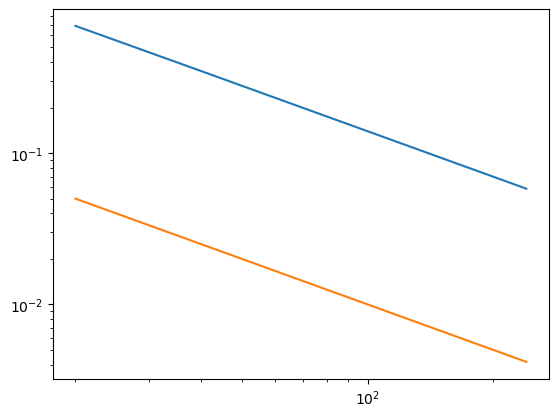

In [30]:
plt.loglog(N_list,k_array)
plt.loglog(N_list,N_list_inv_plot)
plt.show()

The error line is parallel to ref. line meaning it is EOC 1, as expected by set up fixed.

# Working with subdomains


We now solve the same problem but with the forcing function given by:

$$
f(\mathbf{x}) = \begin{cases}
50, & \mathbf{x} \in [0.2, 0.8]^2,\\
1, & \text{otherwise},
\end{cases}
$$


We shall code this using by defining two subdomains:
$$\Omega_2 = [0.2, 0.8]^2 \quad \text{and} \quad \Omega_1 = \Omega \setminus \Omega_0$$

 In order to do so, we need to ensure that the mesh is alligned with the subdomains. For instance, we can take $n=m=10$:

In [31]:
n = 10
m = 10
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

num_cells = mesh.topology.index_map(tdim).size_local
num_cells

200

In [32]:
viskex.dolfinx.plot_mesh(mesh)

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b05972280_5&reconnect=auto" class="pyvi…

In [33]:
boundary_entities = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.full((x.shape[1], ), True))
boundary_entities

array([  0,   3,   4,   6,  12,  14,  23,  25,  37,  39,  54,  56,  74,
        76,  97,  99, 123, 125, 152, 154, 183, 184, 186, 211, 213, 235,
       237, 256, 258, 274, 276, 289, 291, 301, 303, 310, 312, 316, 318,
       319], dtype=int32)

**New Task:** Define the two subdomains $\Omega_1$ and $\Omega_2$ in view of the implementation of the forcing function $f$.

*   mark $\Omega_1$ and $\Omega_2$ with labels `1` and `2`
*   use the `dolfinx.mesh` function `locate_entities` to determine whether a cell is in $\Omega_2$. This function checks each of the three vertices of the triangular cell, and locates all cells in which the provided condition is satisfied on all three vertices.

In [34]:
inner_subdomain_entities = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim, lambda x: np.logical_and(
        np.logical_and(x[0] >= 0.2, x[0] <= 0.8),
        np.logical_and(x[1] >= 0.2, x[1] <= 0.8)))
inner_subdomain_entities

array([ 22,  27,  32,  33,  38,  39,  44,  45,  46,  51,  52,  53,  58,
        59,  60,  61,  66,  67,  68,  69,  74,  75,  76,  77,  78,  83,
        84,  85,  86,  87,  92,  93,  94,  95,  96,  97, 102, 103, 104,
       105, 106, 107, 112, 113, 114, 115, 116, 121, 122, 123, 124, 125,
       130, 131, 132, 133, 138, 139, 140, 141, 146, 147, 148, 153, 154,
       155, 160, 161, 166, 167, 172, 177], dtype=int32)

We label each cell in $\Omega_2$ with the label `2` by using the `np.full` function which return a new array with shape of input filled with value.

In [35]:
inner_subdomains_labels = np.full(inner_subdomain_entities.shape, 2, dtype=np.intc)
inner_subdomains_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int32)

The remaining cells will belong to $\Omega_1$. Recall that in num_cells we have stored the total number of cells


In [36]:
outer_subdomain_entities = np.setdiff1d(np.arange(num_cells), inner_subdomain_entities)
outer_subdomain_entities

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,
        28,  29,  30,  31,  34,  35,  36,  37,  40,  41,  42,  43,  47,
        48,  49,  50,  54,  55,  56,  57,  62,  63,  64,  65,  70,  71,
        72,  73,  79,  80,  81,  82,  88,  89,  90,  91,  98,  99, 100,
       101, 108, 109, 110, 111, 117, 118, 119, 120, 126, 127, 128, 129,
       134, 135, 136, 137, 142, 143, 144, 145, 149, 150, 151, 152, 156,
       157, 158, 159, 162, 163, 164, 165, 168, 169, 170, 171, 173, 174,
       175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [37]:
outer_subdomains_labels = np.full(outer_subdomain_entities.shape, 1, dtype=np.intc)
outer_subdomains_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

We then store both subdomains in a `dolfinx.mesh` `MeshTags` object.

In [38]:
subdomains_entities_unsorted = np.hstack((outer_subdomain_entities, inner_subdomain_entities)).astype(np.int32)
subdomains_values_unsorted = np.hstack((outer_subdomains_labels, inner_subdomains_labels)).astype(np.int32)
subdomains_entities_argsort = np.argsort(subdomains_entities_unsorted)
subdomains_entities_sorted = subdomains_entities_unsorted[subdomains_entities_argsort]
subdomains_values_sorted = subdomains_values_unsorted[subdomains_entities_argsort]
subdomains = dolfinx.mesh.meshtags(
    mesh, mesh.topology.dim, subdomains_entities_sorted, subdomains_values_sorted)
subdomains

We finally plot with `pyvista` the subdomains to verify the correct assignment of the label.

In [39]:
viskex.dolfinx.plot_mesh_tags(mesh, subdomains, "subdomains")

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b04e62850_6&reconnect=auto" class="pyvi…

Defining the FEM space is as before:

In [40]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

Vh_dim = Vh.dofmap.index_map.size_local
Vh_dim

121

In [41]:
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

In order to write this problem in `ufl`, we need to inform the integral measure `dx` of the subdomain labels, using `ufl.Measure` and providing as data the `subdomains` object that we have created.

In [42]:
dx = ufl.Measure("dx")(subdomain_data=subdomains)

The bilinear form is straighforward:

In [43]:
inner = ufl.inner
grad = ufl.grad
A = inner(grad(uh), grad(vh)) * dx

We further define the linear functional
 $$ F(v) = \int_\Omega f \ v \ \mathrm{d}\mathbf{x} = \int_{\Omega_1} v \ \mathrm{d}\mathbf{x} + \int_{\Omega_2} 50 \ v \ \mathrm{d}\mathbf{x}.$$
 In order to implement this in `ufl`, we use `dx(1)` to define integration over $\Omega_1$, and similarly `dx(2)` to define integration over $\Omega_2$.

In [44]:
F = vh * dx(1) + 50 * vh * dx(0) # f = 1 on omega 1 and 50 on omega 2

In [45]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

solution = dolfinx.fem.Function(Vh)

problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

In [46]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)

In [47]:
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

In [48]:
# Due to new version of dolfinx I needed to change the way to plot the solution


u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = solution.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b0635b640_7&reconnect=auto" class="pyvi…

Point 2

Use the subdomain idea to solve the problem: find $u: \Omega = (0, 1)^2 \to \mathbb{R}$ such that

$$
\begin{cases}
- \nabla (\kappa \nabla u) = f, & \text{in } \Omega,\\
u = g, & \text{on } \partial\Omega.
\end{cases}
$$
with $f$  and $g$ as before and
$$
\kappa(\mathbf{x}) = \begin{cases}
1, & \mathbf{x} \in [0.2, 0.8]^2,\\
0.1, & \text{otherwise},
\end{cases}
$$

The two subdomains are the same as before, so no need to re-write the code. Also F could be coded in the same way as before, however, the problem is bilinear operator, since now there is a function inside to be evaluated correctly. Indeed expand how the bilinear operator is written and it is clear that is the sum of $-k \bigtriangleup u$ and $\nabla k \nabla u$. Now, k is a horizontal line step function, meaning that inside each of teh subdomains the first derivative is 0. This means that $\nabla k = 0$, so the expansion of the bilinear form becomes $-k \bigtriangleup u +\nabla k 0 = -k \bigtriangleup u $ .

Define the code for bilinear operator and linear operator:

In [49]:
inner = ufl.inner
grad = ufl.grad
A = inner(grad(uh), grad(vh)) * dx(2) + 0.1 * inner(grad(uh), grad(vh)) * dx(1) # since k=1 in omega 1 and 1/10 in omega 2

F = vh * dx(1) + 50 * vh * dx(2) # as before, since f=1 in omega 1 and f=50 in omega 2

In [50]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1))

boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_entities)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

solution = dolfinx.fem.Function(Vh)

problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

In [51]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Due to new version of dolfinx I needed to change the way to plot the solution


u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = solution.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b04f27850_8&reconnect=auto" class="pyvi…

Point 3

Use the subdomain idea to define different boundary conditions. For instance, solve with:
$$
-\bigtriangleup u = f \\
u = g \quad\text{if } \quad x=0 \quad \text{or}\quad  x=1,
$$
$$
f(\mathbf{x}) = \begin{cases}
50, & \mathbf{x} \in [0.2, 0.8]^2,\\
1, & \text{otherwise},
\end{cases}
$$

and
$$
-\frac{\partial u}{\partial {\mathbf n}} = h \quad \text{otherwise}.
$$
with
$$
h(x,y)=
\left\{
\begin{array}{ll}
0 & \text{if } y=0\\
-4 & \text{if } y=1.
\end{array}
\right.
$$


The basic mesh will be the same used before, so no need to rewrite the code.

For the boundary condition there is a mix of Dirichlet and Neumann conditions, so it is defined as mixed problem. Again Poisson problem.

The main reference used to solve this problem is: https://jsdokken.com/dolfinx-tutorial/chapter3/neumann_dirichlet_code.html

The first step is re-write the problem, as usual, in weak form: by testing v and integration by part

$$
-\int_{\Omega} \bigtriangleup u dx = \int_{\Omega} \nabla u \nabla v dx - \int_{\partial \Omega} \frac{\partial u}{\partial n} v dx = \int_{\Omega} \nabla u \nabla v dx - 0 - \int_{\partial \Omega_{N}} \frac{\partial u}{\partial n} v dx = \int_{\Omega} \nabla u \nabla v dx  - \int_{\partial \Omega_{N}} -h v dx = \int_{\Omega} \nabla u \nabla v dx  + \int_{\partial \Omega_{N}} h v dx
$$

since on Dirichlet subdomain it is fixed a V space where v = 0.

Re-write the problem in weak form:

$$
A(u, v) = F(v) 
$$
which form is:
$$
A(u, v) = \int_{\Omega} \nabla u \nabla v dx  + \int_{\partial \Omega_{N}} h v dx \\

F(v) = \int_{\Omega} f v dx
$$

but for simplicity, let's work with usual bilinera operator defined by inner product of gradients:
$$
A(u, v) = \int_{\Omega} \nabla u \nabla v dx   \\

F(v) = \int_{\Omega} f v dx - \int_{\partial \Omega_{N}} h v dx
$$

Vh, uh and vh are the same as before, so no need to re write them. The second step as usual is to define the code for split the domain $\Omega$ in the subdoamins: here, for simplicity in coding, it is possible to split the domain in:

* Dirichelt lower bound $x = 0$
* Dirichlet upper bound $x = 1$
* Neumann lower bound $y = 0$
* Neumann upper bound $y = 1$
* Squared inner domain based of f
* Squared outer domain based of f


In [52]:
n = 10
m = 10
mesh = dolfinx.mesh.create_unit_square(mpi4py.MPI.COMM_WORLD, n, m)

num_cells = mesh.topology.index_map(tdim).size_local
num_cells

200

In [53]:
# Now use same approach for outer and ineer subdomains fo F used before, so use locate_entities
bnd_ent_lower_Neum = dolfinx.mesh.locate_entities(
    mesh, fdim+1, lambda x: np.isclose(x[1], 0, atol=0.1)) #meaning y = 0

bnd_ent_upper_Neum = dolfinx.mesh.locate_entities(
    mesh, fdim+1, lambda x: np.isclose(x[1], 1, atol=0.1)) #meaning y = 1

# here, on code implementation I needed to set different tollerance because otherwise it was not able to select the Neumann boundaries.

In [54]:
# same function as before
inn_ent_f = dolfinx.mesh.locate_entities(
    mesh, mesh.topology.dim, lambda x: np.logical_and(
        np.logical_and(x[0] >= 0.2, x[0] <= 0.8),
        np.logical_and(x[1] >= 0.2, x[1] <= 0.8)))

Now it is important to actual create the outer domain, using the same approach used before, but the only difference relies on the set unions by Dirichlet and Neumann.

In [55]:
outer_step1 = np.setdiff1d(np.arange(num_cells), inn_ent_f) #usual as before
outer_step2 = np.setdiff1d(outer_step1, bnd_ent_lower_Neum) #remove lower bound of Neumann
outer_step3 = np.setdiff1d(outer_step2, bnd_ent_upper_Neum) #remove upper bound of Neumann

Now, as usual, label the division created

In [56]:
inner_label = np.full(inn_ent_f.shape, 1)
neum_lower_label = np.full(bnd_ent_lower_Neum.shape, 2)
neum_upper_label = np.full(bnd_ent_upper_Neum.shape, 3)
outer_label = np.full(outer_step3.shape, 4)

In [57]:
sub_ent_unsorted = np.hstack((inn_ent_f, bnd_ent_lower_Neum, bnd_ent_upper_Neum, outer_step3)).astype(np.int32)
sub_label_unsorted  = np.hstack((inner_label, neum_lower_label, neum_upper_label, outer_label)).astype(np.int32)
sub_ent_sorted = sub_ent_unsorted[np.argsort(sub_ent_unsorted)]
sub_label_sorted = sub_label_unsorted[np.argsort(sub_ent_unsorted)]
subdomains = dolfinx.mesh.meshtags(
    mesh, mesh.topology.dim, sub_ent_sorted, sub_label_sorted)

In [58]:
viskex.dolfinx.plot_mesh_tags(mesh, subdomains, "subdomains")

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b04f0edc0_9&reconnect=auto" class="pyvi…

Here, there is the blue inner boundary, derived by F. Also, the red is outer boundary obtained by F. The two line of traingles on top (yellow) and on bottom (cyan) represent the Neumann one.

Now, that the domain is defined, as usual define the space and test function

In [59]:
Vh = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

Vh_dim = Vh.dofmap.index_map.size_local
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

As before, define the dx on the appropriate measure in domain

In [60]:
dx = ufl.Measure("dx")(subdomain_data=subdomains)

Bilinear operator and linear one

In [61]:
inner = ufl.inner
grad = ufl.grad
# here define the same inner product on all the 4 subdomains
A = inner(grad(uh), grad(vh)) * dx(1) + inner(grad(uh), grad(vh)) * dx(2) + inner(grad(uh), grad(vh)) * dx(3) + inner(grad(uh), grad(vh)) * dx(4)
# now on F, the topic is to get what happens on each subdomains since we put there also the neumann part
F = vh * dx(4) + 50 * vh * dx(1) + vh * dx(3) + 4* vh * dx(3) + vh * dx(2) # as before, since f=1 in omega 1 (outer/red)and f=50 in omega 2 (inner/blue), h = -4 when in upper Neumann (yellow) and h = 0 when in lower Neumann (cyan)

In [62]:
gh = dolfinx.fem.Function(Vh)
gh.interpolate(lambda x: np.sin(3 * np.pi * x[0] + 1) * np.sin(3 * np.pi * x[1] + 1)) # as before, data as before

# Dirichlet conditions
boundary_dirichlet = dolfinx.mesh.locate_entities_boundary(
    mesh, fdim, lambda x: np.logical_or(np.isclose(x[0], 0), np.isclose(x[0], 1)))

boundary_dofs = dolfinx.fem.locate_dofs_topological(Vh, fdim, boundary_dirichlet)
bc = dolfinx.fem.dirichletbc(gh, boundary_dofs)

solution = dolfinx.fem.Function(Vh)

problem = dolfinx.fem.petsc.LinearProblem(
    A, F, bcs=[bc], u=solution,
    petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type": "mumps"})
_ = problem.solve()

In [ ]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry) #used same as before, indeed not changed

# Due to new version of dolfinx I needed to change the way to plot the solution


u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = solution.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

Widget(value='<iframe src="http://localhost:35885/index.html?ui=P_0x759b04f0e9a0_10&reconnect=auto" class="pyv…

The results is enough clear, with boundaris on left and right side and the core in the middle and a litte lower intensity in top center and bottom center. On left and right side the lower values of the solution.